In [2]:
#Import Libraries

from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()
import pandas as pd
!pip install lmfit
import lmfit

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


<img src="images/model.png">

### Time Dependent R0

<img src="images/r0.png">

### Fitting an extended SIR model with time-dependent R₀-values and resource-dependent death rates to actual Coronavirus data

Limitations of the model:

1. Extremely sensitive to initial parameters
2. Presence of unreliable data
3. Not accounting for hotspots and assuming homegeneity
4. Assuming deaths do not change population structure
5. Individuals are immune after recovery

δ and γ are fixed to δ=1/9 and γ=1/3 (estimated through various experiments and research papers)

Parameters to fit:

1. R0_start
2. R0_end
3. x0 in R0(t)
4. k in R0(t)

In [3]:
#Set of differential equations for the SEIRD Model

def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [4]:
N = 1_300_000_000 #Total Population
D = 3.0 #number of days an infected person has and can spread the disease
gamma = 1.0 / D #the proportion of infected recovering per day
delta = 1.0 / 9.0  # incubation period
alpha = 0.028  # 2.8% death rate
rho = 1/9  # 9 days from infection until death

# R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5
#Earlier we had these now we have to fit them 

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days,R_0_start, k, x0, R_0_end):
    
    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    S0, E0, I0, R0, D0 = N-1.0, 1.0, 0.0, 0.0, 0.0  # initial conditions: one exposed
    y0 = S0, E0, I0, R0, D0 # Initial conditions vector
    t = np.linspace(0, days-1, days)
    
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S, E, I, R, D = ret.T
    
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t,S,E,I,R,D,R_0_over_time

In [5]:
#Loading and preprocesssing the data
#Needs to be changed
df=pd.read_csv('national_data.csv')
# df=df.loc[:,['cases_time_series__totaldeceased']]
# data=df['cases_time_series__totaldeceased'].values[::]
df=df.loc[:,['cases_time_series__totalconfirmed']]
data=df['cases_time_series__totalconfirmed'].values[::]
y_data=data
days=len(data)
x_data = np.linspace(0, days - 1, days, dtype=int)

In [6]:
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days,R_0_start, k, x0, R_0_end)
    # Model returns bit tuple. 6-th value (index=6) is list with deaths per day.
    return ret[2][x]+ret[3][x]+ret[4][x]

In [7]:
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5)}  # form: {parameter: (initial guess, minimum value, max value)}

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [8]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

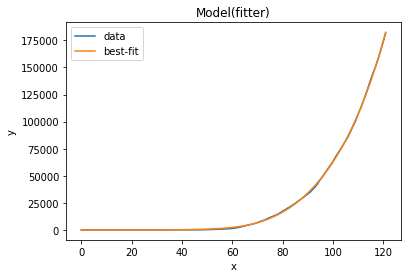

In [9]:
result.plot_fit(datafmt="-");

In [10]:
result.best_values

{'R_0_start': 2.9484331494959855,
 'k': 0.10045912065563693,
 'x0': 72.27642742662388,
 'R_0_end': 1.5188625428253977}

In [11]:
pred=Model(130,**result.best_values)

In [12]:
pred_total=(pred[2][122:128]+pred[3][122:128]+pred[4][122:128])
print(pred_total)

[191299.00637318 200451.89298469 209994.21788225 219942.35727656
 230313.38586528 241125.10613994]


In [13]:
act_total=np.array([190648,198371,207186,216875,226722,236184])
print(act_total)

[190648 198371 207186 216875 226722 236184]


In [14]:
mse=((pred_total-act_total)**2).mean()

In [15]:
print(mse)

9893545.927904224


### Model Predictions:

* 31 May: 191299
* 1 June: 200451
* 2 June: 209994
* 3 June: 219942
* 4 June: 230313
* 5 June: 241125

### Actual Total Cases:

* 31 May: 190648
* 1 June: 198371
* 2 June: 207186
* 3 June: 216875
* 4 June: 226722
* 5 June: 236184

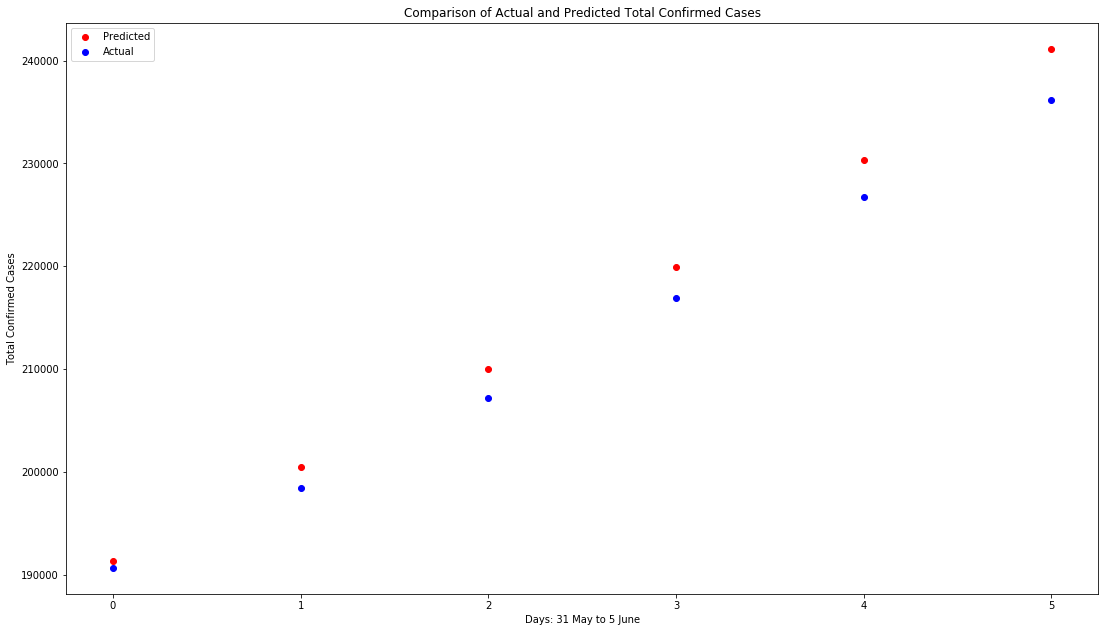

In [22]:
plt.plot(pred_total,'ro',label='Predicted')
plt.plot(act_total,'bo',label='Actual')
plt.ylabel('Total Confirmed Cases')
plt.xlabel("Days: 31 May to 5 June")
plt.title("Comparison of Actual and Predicted Total Confirmed Cases")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("modelreadings.png")